
⚙️ Training Support Vector Machine...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Best SVM Params: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}

🔍 SVM Validation:
              precision    recall  f1-score   support

           5       0.75      0.84      0.79        55
           6       0.75      0.70      0.72        71
           7       0.57      0.53      0.55        60
           8       0.63      0.66      0.65        61

    accuracy                           0.68       247
   macro avg       0.68      0.68      0.68       247
weighted avg       0.68      0.68      0.68       247

✅ Accuracy: 0.680161943319838

📊 SVM Test:
              precision    recall  f1-score   support

           5       0.79      0.78      0.79        79
           6       0.77      0.80      0.79        69
           7       0.61      0.62      0.62        74
           8       0.72      0.70      0.71        87

    accuracy                           0.72       309
   macro avg

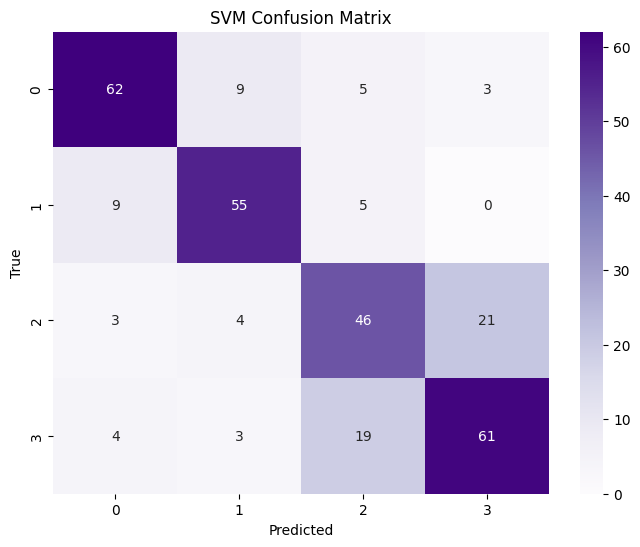

In [1]:
import os
import cv2
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract color histogram features
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
        return None
    image = cv2.resize(image, (128, 128))  # Resize to standard size
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten()

# Load data
main_dir = "Split_Data"
data = []
labels = []

for phase in ["train", "test"]:
    phase_path = os.path.join(main_dir, phase)
    for root, dirs, files in os.walk(phase_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                full_path = os.path.join(root, file)
                match = re.search(r'pH(\d+)', file)
                if match:
                    pH = int(match.group(1))
                    features = extract_features(full_path)
                    if features is not None:
                        data.append(features)
                        labels.append(pH)
                else:
                    print(f"Could not extract pH from: {file}")

# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

# Split data
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)


# -------------------------- SVM --------------------------
print("\n⚙️ Training Support Vector Machine...")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, n_jobs=-1, verbose=1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
print(f"✅ Best SVM Params: {grid_svm.best_params_}")

val_preds_svm = best_svm.predict(X_val)
print("\n🔍 SVM Validation:")
print(classification_report(y_val, val_preds_svm))
print("✅ Accuracy:", accuracy_score(y_val, val_preds_svm))

test_preds_svm = best_svm.predict(X_test)
print("\n📊 SVM Test:")
print(classification_report(y_test, test_preds_svm))
print("✅ Accuracy:", accuracy_score(y_test, test_preds_svm))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, test_preds_svm), annot=True, fmt='d', cmap='Purples')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
